In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential, utils, layers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import math

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.


2024-10-17 18:07:57.835163: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-17 18:07:57.835199: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-17 18:07:57.835210: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-17 18:07:57.835226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-17 18:07:57.835237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-17 18:07:58.041759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


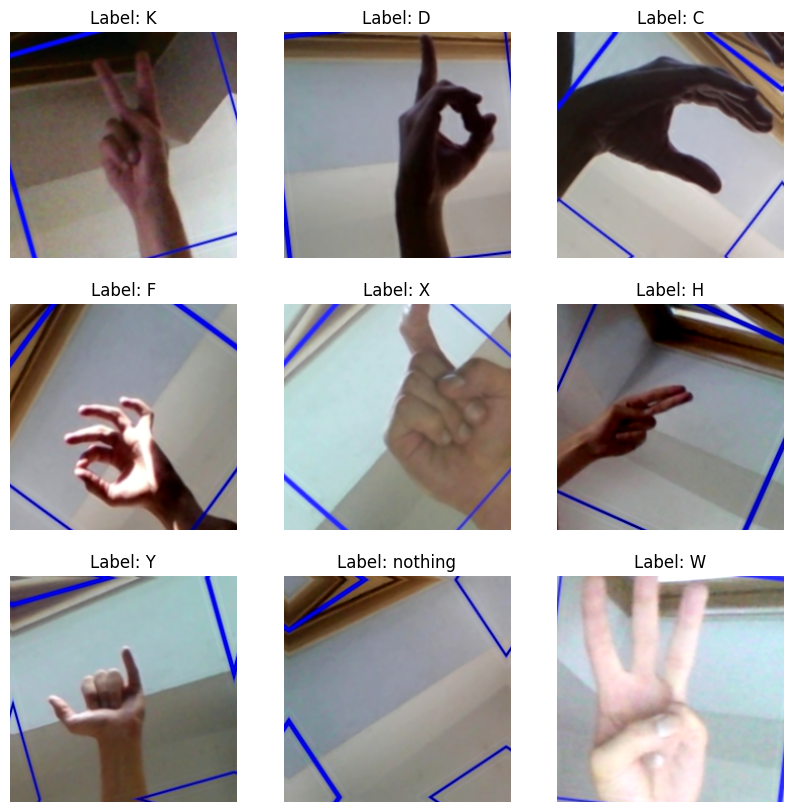

In [2]:
imgSize = 224
batchSize = 512
basePath = os.getcwd()
dataPath = os.path.join(basePath, 'data/asl_alphabet_train')

dsTrain, dsVal = utils.image_dataset_from_directory(
    dataPath,
    image_size = (imgSize,imgSize),
    batch_size = batchSize,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    seed=123
)
class_names = dsTrain.class_names

augmentation = Sequential([
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])
rescaling = layers.Rescaling(1./255)

# Apply preprocessing to the training dataset
dsTrain = dsTrain.map(
    lambda x, y: (rescaling(augmentation(x, training=True)), y)
)

# Apply preprocessing to the validation dataset
dsVal = dsVal.map(
    lambda x, y: (rescaling(x), y)
)

# Optional: Prefetch for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
dsTrain = dsTrain.prefetch(buffer_size=AUTOTUNE)
dsVal = dsVal.prefetch(buffer_size=AUTOTUNE)

dsIter = iter(dsTrain)

augementedImage, labels = next(dsIter)
plt.figure(figsize=(10, 10))

for i in range(9):  # Display 9 augmented images
    plt.subplot(3, 3, i + 1)
    plt.imshow(augementedImage[i].numpy())  # Convert tensor to NumPy array and display
    class_index = np.argmax(labels[i].numpy())
    class_name = class_names[class_index]
    plt.title(f"Label: {class_name}")
    plt.axis('off')  # Turn off axis labels for cleaner visualization
    
plt.show()


In [3]:
dsTrain = dsTrain.repeat()
dsVal = dsVal.repeat()
model = Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(imgSize, imgSize, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(29, activation='softmax')
])

model.summary()

/Users/zixu/miniforge3/envs/dl-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,172,701 (42.62 MB)

 Trainable params: 11,172,701 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
steps_per_epoch = math.ceil(69600 / batchSize)  # Adjust based on your dataset size
validation_steps = math.ceil(17400 / batchSize)  # Adjust as needed

# Update learning rate
opt = optimizers.Adam(learning_rate=0.001)  # Lower learning rate

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    dsTrain,
    steps_per_epoch=steps_per_epoch,
    validation_data=dsVal,
    validation_steps=validation_steps,
    epochs=20,  # Increase epochs
    callbacks=[early_stopping]
)

Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.0936 - loss: 3.2139 - val_accuracy: 0.2866 - val_loss: 2.3711
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.3242 - loss: 2.2276 - val_accuracy: 0.5214 - val_loss: 1.5682
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.4915 - loss: 1.6358 - val_accuracy: 0.6248 - val_loss: 1.1763
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.5931 - loss: 1.2654 - val_accuracy: 0.7121 - val_loss: 0.9256
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.6727 - loss: 1.0135 - val_accuracy: 0.7731 - val_loss: 0.7188
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.7273 - loss: 0.8415 - val_accuracy: 0.7904 - val_loss: 0.6686
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.7701 - loss: 0.7052 - val_accuracy: 0.8141 - val_loss: 0.5865
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.7927 - loss: 0.6319 - val_accu

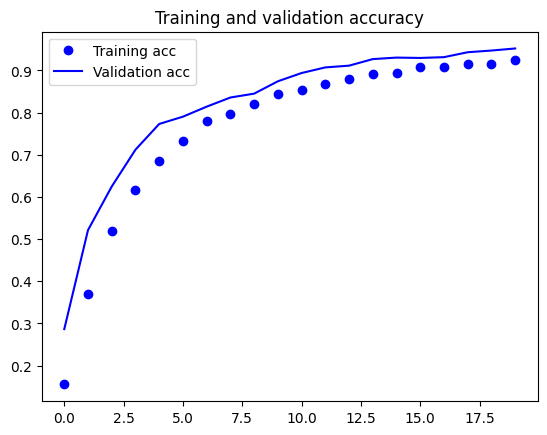

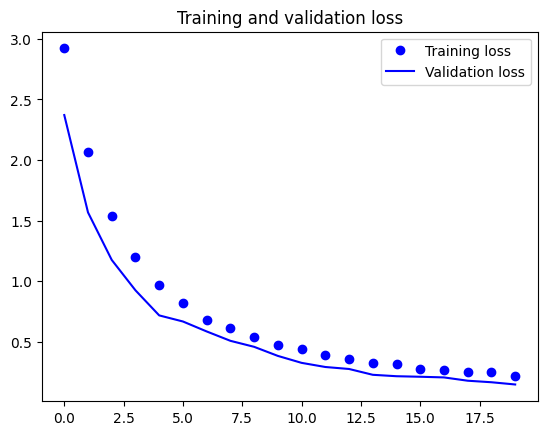

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
model2 = Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(imgSize, imgSize, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),  # Increased Dense layer
    layers.BatchNormalization(),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(29, activation='softmax')  # Output layer with 29 classes
])

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,865,949 (37.64 MB)

 Trainable params: 9,864,221 (37.63 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [16]:
# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Stop training early if validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model during training
checkpoint = ModelCheckpoint(basePath+'/best_model.keras', monitor='val_loss', save_best_only=True)
opt2 = optimizers.Adam(learning_rate=0.001)
# Compile and fit your model
model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(
    dsTrain,
    validation_data=dsVal,
    epochs=50,
    callbacks=[reduce_lr, early_stopping, checkpoint],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/50
 41/136 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - accuracy: 0.1614 - loss: 3.1906